Ли-Зан-Мен Сергей MLOps-22

Этот ноутбук содержит мою попытку без гуглежа решить задачу. Реализация была на mps из-за чего дальше будет много боли:)

In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import char_error_rate
from torchvision import transforms
from torchinfo import summary

from PIL import Image

import warnings 
warnings.filterwarnings('ignore')

/Users/vyavvya/Projects/MADE/intensive_deep_learning/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
RANDOM_STATE = 2
TRAIN_SIZE = 0.8
DATA_PATH = './samples'

TRAIN_BATCH_SIZE = 2

SIZE_W = 200
SIZE_H = 50

LABEL_LENGTH = 5 + 1 # End-symbol

In [5]:
device = 'cpu'

# проверить, доступна ли у вас CUDA. 
if torch.cuda.is_available():
    device = 'cuda'
    
try: # на mps не считается CTCloss
    if torch.backends.mps.is_available():
        device = 'mps'
except Exception:
    pass

print('Device:', device)

Device: mps


# 1.Подготовка данных. 
1. Реализовал класс датасет для данных
2. Считываю изображения как gray-scale, тк они все ч/б
3. В конце к каждом лейблу символ окончания, чтобы на предикте рубить строку по нему (идея из прошлого курса по МЛ). Также не знал, про бланк в CTC, поэтому добавлял свой разделитель
4. Для нормализации изображений сперва считаю статистики по всему датасету, чтоыб закрепить их
5. Делю на трейн/тест

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.img_names = [
            file_name for file_name in  os.listdir(img_dir) 
            if file_name.endswith('.png') or file_name.endswith('.jpg')
        ]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('L') # To gray-scale
        label = self.img_names[idx].split('.')[0] + '$' # end-symbol
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Get mean and std

transform_compose =transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[0], std=[1])
])

full_dataset = ImageDataset(DATA_PATH, transform=transform_compose) # Return normalized tensor (C, H, W)
full_loader = DataLoader(full_dataset, batch_size=len(full_dataset))
images, labels = next(iter(full_loader)) # Images (B, C, H, W) = (1070, 1, 50, 200)

# Get mean and std by (batch, width, height)
mean_images = images.mean([0, 2, 3])
std_images = images.std([0, 2, 3])
print('\nMean:', mean_images)
print('Std:', std_images)

# Get id for each symbol from dataset
all_symbols = sorted(set(''.join(labels))) 

symbol2id = dict(zip(all_symbols, range(1, len(all_symbols) + 1)))
symbol2id['_'] = 0 # blank
id2symbol = {v: k for k, v in symbol2id.items()}

print('Symbol for id:', symbol2id)
print('Id for symbol:', id2symbol)


Mean: tensor([182.3633])
Std: tensor([80.0027])
Symbol for id: {'$': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, 'b': 9, 'c': 10, 'd': 11, 'e': 12, 'f': 13, 'g': 14, 'm': 15, 'n': 16, 'p': 17, 'w': 18, 'x': 19, 'y': 20, '_': 0}
Id for symbol: {1: '$', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: 'b', 10: 'c', 11: 'd', 12: 'e', 13: 'f', 14: 'g', 15: 'm', 16: 'n', 17: 'p', 18: 'w', 19: 'x', 20: 'y', 0: '_'}


In [43]:
def label_to_tensor(label_str: str) -> torch.Tensor:
    v = torch.zeros(LABEL_LENGTH)
    for i, sym in enumerate(label_str):
        v[i] = symbol2id[sym]
    return v

In [44]:
# Fixing constants 
IMAGE_MEAN = 182.3633
IMAGE_STD = 80.0027

assert np.isclose(IMAGE_MEAN, mean_images) 
assert np.isclose(IMAGE_STD, std_images) 

transform_compose =transforms.Compose([
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.float()),
    transforms.Normalize(mean=[IMAGE_MEAN], std=[IMAGE_STD])
])

full_dataset = ImageDataset(DATA_PATH, transform=transform_compose, target_transform=label_to_tensor)

torch.manual_seed(RANDOM_STATE)

train_size = int(TRAIN_SIZE * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

print(f'Full shape: {len(full_dataset)}')
print(f'Train shape: {len(train_dataset)}')
print(f'Test shape: {len(test_dataset)}')

Full shape: 1070
Train shape: 856
Test shape: 214


In [45]:
test_dataset[0][0].shape

torch.Size([1, 50, 200])

# 2.Создание и обучение модели
1. Не удалял закоменченные строки
2. Я реализовал модель из описания лабы, но она давала намного хуже скор. Плюс училась супер долго. Проблема была в СТС-лоссе, который у меня заваливался в NaN (его нельзя использовать на mps, поэтому кидал его туда-сюда), но до этой мысли я доходил очень долго. Также маленькое число сверточных слоев, думал, что и так много.
3. В итоге удалил лстм и пермут, чем получил скор 20 CER
4. Оставил как память о поле битвы

In [73]:
def conv_block_3x3(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, (3, 3), stride=(1, 1), padding=(1, 1)),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )


class OCRModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.cn = nn.Sequential(
            conv_block_3x3(1, 32),
            conv_block_3x3(32, 64),
            conv_block_3x3(64, 128),
            conv_block_3x3(128, 256),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(SIZE_H * SIZE_W, 256),
            nn.Dropout(0.25)
        )
        self.hidden_size = 256
        self.num_layers = 2
        self.d = 2

        self.lstm = nn.LSTM(
            input_size = 256,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            bidirectional = True,
            dropout = 0.25,
            batch_first=True
        )
        self.output = nn.Linear(256, len(symbol2id)) # blank already added

    def forward(self, x, h=None, c=None):
        x = self.cn(x)

        # x = x.permute(0, 3, 1, 2)  # (B, C, H, W) -> (B, W, C, W) если добавляю, то лосс выше
        x = x.view(x.size(0), x.size(1), -1) # (B, C, H, W) -> (B, C, H * W)

        x = self.fc(x)

        # h = torch.rand(self.d * self.num_layers, x.size(0), self.hidden_size, requires_grad=True).to(device)  # (D * num_layers, B, H out)
        # c = torch.rand(self.d * self.num_layers, x.size(0), self.hidden_size, requires_grad=True).to(device)  # (D * num_layers, B, H cell)       
        
        # x, _ = self.lstm(x, (h, c)) # если добавляю, то лосс намного выше (порядка 8) и обучение сверх долгое
        x = self.output(x)

        x = x.permute(1, 0, 2) # (B, W, N sym) -> (W, B, N sym) 
        return x


In [74]:
m = OCRModel() # model shape
summary(m, (TRAIN_BATCH_SIZE, 1, SIZE_H, SIZE_W), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
OCRModel                                 [256, 2, 21]              2,629,632
├─Sequential: 1-1                        [2, 256, 50, 200]         --
│    └─Sequential: 2-1                   [2, 32, 50, 200]          --
│    │    └─Conv2d: 3-1                  [2, 32, 50, 200]          320
│    │    └─BatchNorm2d: 3-2             [2, 32, 50, 200]          64
│    │    └─ReLU: 3-3                    [2, 32, 50, 200]          --
│    └─Sequential: 2-2                   [2, 64, 50, 200]          --
│    │    └─Conv2d: 3-4                  [2, 64, 50, 200]          18,496
│    │    └─BatchNorm2d: 3-5             [2, 64, 50, 200]          128
│    │    └─ReLU: 3-6                    [2, 64, 50, 200]          --
│    └─Sequential: 2-3                   [2, 128, 50, 200]         --
│    │    └─Conv2d: 3-7                  [2, 128, 50, 200]         73,856
│    │    └─BatchNorm2d: 3-8             [2, 128, 50, 200]         2

In [75]:
model = OCRModel().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
loss_func = nn.CTCLoss(blank=0, zero_infinity=True)


history_loss = []

In [76]:
def compute_ctc_loss(text_batch_logits, text_batch):
    '''
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    '''
    text_batch_logits = text_batch_logits.to('cpu')
    text_batch_logps = F.log_softmax(text_batch_logits, 2).to('cpu') # [T, batch_size, num_classes] 

    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), fill_value=text_batch_logps.size(2), dtype=torch.int32).to('cpu')
                                       

    text_batch_targets_lens = torch.full(size=(labels.size(0),), fill_value=LABEL_LENGTH, dtype=torch.int32).to('cpu')

    loss = loss_func(text_batch_logps, text_batch, text_batch_logps_lens, text_batch_targets_lens).to(device)
    return loss

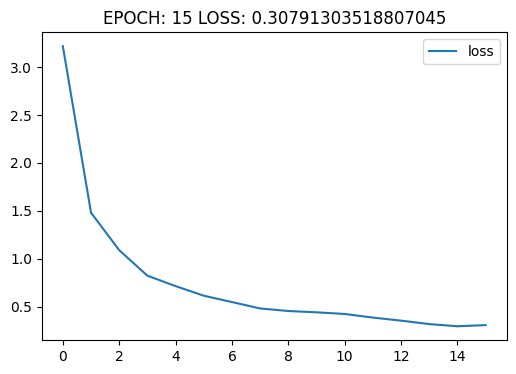

loss=0.09613212198019028:  26%|██▌       | 112/428 [00:10<00:29, 10.53it/s] 


KeyboardInterrupt: 

In [85]:
torch.manual_seed(RANDOM_STATE)

N_EPOCH = 20

model.train()
for i_ep in range(len(history_loss), len(history_loss) + N_EPOCH):
    epoch_loss = []

    t = tqdm(train_loader)
    for data in t:
        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients for every batch
        opt.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = compute_ctc_loss(outputs, labels)

        epoch_loss.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Adjust learning weights
        opt.step()
        t.set_description(f'loss={loss.item()}')

    epoch_loss = np.mean(epoch_loss)

    # Plot train loss
    history_loss.append(epoch_loss)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    clear_output(True)
    ax.plot(history_loss, label='loss')
    ax.legend()
    ax.set_title(f'EPOCH: {i_ep} LOSS: {epoch_loss}')
    plt.show()


# 3.Подсчет метрик. 
1. Восстанавливаю ответ удалением дублей, делю по '_' и беру первую часть при делении по '$'
2. CER сперва считал сам, думал просто число ошибок. Оставил как легаси, но использую функцию из торча
3. Финальный CER = 20 

In [86]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ''
    return ''.join(letters)


def correct_prediction(word):
    parts = word.split('_')
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = ''.join(parts)
    corrected_word = corrected_word.split('$')[0]
    return corrected_word


def decode_predictions(preds):
    preds = preds.permute(1, 0, 2) # (B, T, Classes)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    cap_preds = []
    for i_ts in range(preds.shape[0]):
        temp = []
        for i_sym in preds[i_ts]:
            sym = id2symbol[i_sym.item()]
            temp.append(sym)
        cap_preds.append(correct_prediction(''.join(temp)))
    return cap_preds


def get_label_from_ids(label_ids):
    labels = []
    for i_batch in range(label_ids.size(0)):
        label = ''
        for i_sym in label_ids[i_batch]:
            label += id2symbol[i_sym.item()]
        labels.append(label[:-1])
    return labels


def get_character_error_rate(logits, label_ids):
    """
    Get Character Error
    """
    labels = get_label_from_ids(label_ids)
    preds = decode_predictions(outputs)
    return labels[0], preds[0], char_error_rate(preds, labels)
    
    # It is my CER:)
    # Total errors
    # amount_error = 0
    # for i_pred in range(len(preds)):
    #     for i_sym in range(len(preds[i_pred])): # For each label
    #         if len(labels[i_pred]) <= i_sym or preds[i_pred][i_sym] != labels[i_pred][i_sym]:
    #             amount_error += 1
    #     if len(preds[i_pred]) < len(labels[i_pred]):
    #         amount_error += len(labels[i_pred]) - len(preds[i_pred])
    return amount_error


In [88]:
torch.manual_seed(RANDOM_STATE)

model.eval()
# total_cer_test = 0
bad_predict = []
good_predict = []
all_labels = []
all_pred_labels = []
t = tqdm(range(len(test_dataset)))
for i in t:
    # Every data instance is an input + label pair
    inputs, labels = test_dataset[i]
    inputs, labels = inputs.to(device), labels.to(device)
    inputs, labels = inputs.unsqueeze(0), labels.unsqueeze(0)
    with torch.no_grad():
        outputs = model(inputs)

    label, pred_label, cer = get_character_error_rate(outputs, labels)
    all_labels.append(label)
    all_pred_labels.append(pred_label)

    t.set_description(f'cer={cer.item()}')
    # total_cer_test += cer
    label_output = decode_predictions(outputs)
    if cer > 0.1:
        bad_predict.append((cer, i, label_output))
    else:
        good_predict.append((cer, i, label_output))

# total_cer_test /= len(test_dataset) * (LABEL_LENGTH - 1)
total_cer_test = char_error_rate(all_pred_labels, all_labels)
print('Test CER:', total_cer_test.item())

cer=0.4000000059604645: 100%|██████████| 214/214 [00:29<00:00,  7.22it/s] 


Test CER: 0.2046729028224945


# 4.Анализ ошибок модели
1. Разобраться с лстм и пермутом)
2. Больше сверточных слоев
3. Гугл сила
4. Результаты не такие плохие, нет ситуаций, где модель не определила все буквы, и парочку где неопределила 4 из 5

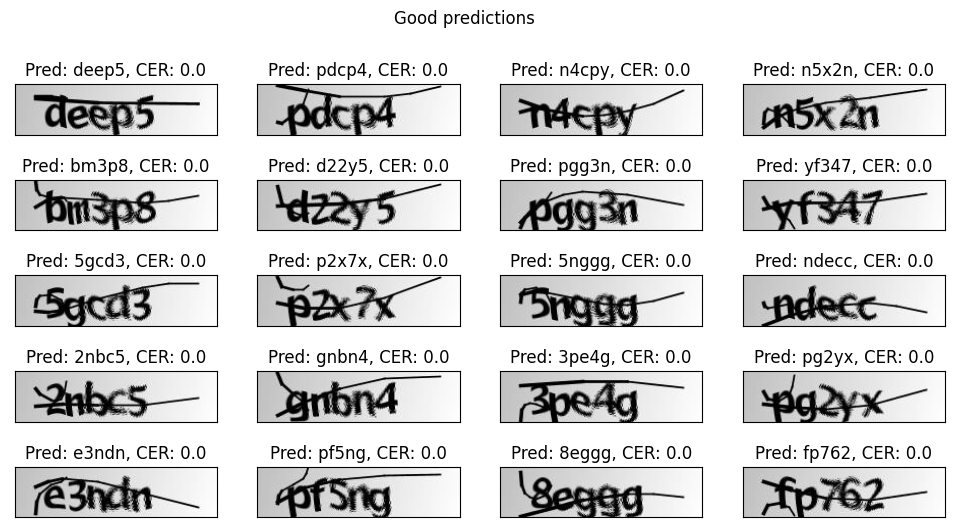

In [89]:
fig, axes = plt.subplots(5, 4, figsize=(12, 6))
fig.suptitle('Good predictions')
axes = axes.flat

for i, (cer, i_img, pred_label) in enumerate(sorted(good_predict, key=lambda x: x[0])[:20]):
    true_label = get_label_from_ids(test_dataset[i_img][1].unsqueeze(0))
    axes[i].imshow(Image.fromarray(test_dataset[i_img][0].numpy().squeeze() * IMAGE_STD + IMAGE_MEAN).convert('L'), cmap='gray')
    axes[i].set_title(f'Pred: {pred_label[0]}, CER: {round(cer.item(), 4)}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])

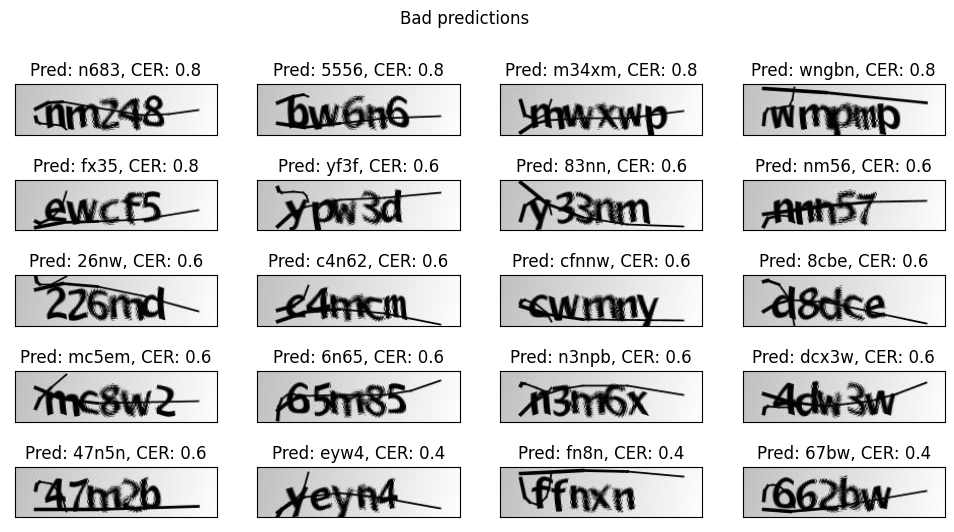

In [90]:
fig, axes = plt.subplots(5, 4, figsize=(12, 6))
fig.suptitle('Bad predictions')
axes = axes.flat

for i, (cer, i_img, pred_label) in enumerate(sorted(bad_predict, key=lambda x: x[0], reverse=True)[:20]):
    true_label = get_label_from_ids(test_dataset[i_img][1].unsqueeze(0))
    axes[i].imshow(Image.fromarray(test_dataset[i_img][0].numpy().squeeze() * IMAGE_STD + IMAGE_MEAN).convert('L'), cmap='gray')
    axes[i].set_title(f'Pred: {pred_label[0]}, CER: {round(cer.item(), 4)}')
    axes[i].set_xticks([])
    axes[i].set_yticks([])